# Gesture Recognition
<b> Use Tensorflow 2.10.0 </b>

## 1. Data Loader and Analysis

In [1]:
# import library
import os, glob, shutil
import numpy as np
import datetime
import tensorflow as tf
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from keras.layers import Dense,Dropout,Conv3D,Input,MaxPool3D,Flatten,Activation
from keras.regularizers import l2
from keras.models import Model

# set random seed for whole project
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# setting global parameter
data_folder = './data'
checkpoints_folder = './checkpoints'

# setting hyparameter for project
batch_size = 8
num_epochs = 30
dest_size = (128, 128)

### 1.1 Read CSV file

In [3]:
train_doc = np.random.permutation(open('./data/train.csv').readlines())
val_doc = np.random.permutation(open('./data/val.csv').readlines()) 
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'), delimiter=';', names=['video', 'label (text)', 'label'])
val_df   = pd.read_csv(os.path.join(data_folder, 'val.csv'), delimiter=';', names=['video', 'label (text)', 'label'])
print('Total train samples :', len(train_df))
print('Total val samples   :', len(val_df))

Total train samples : 663
Total val samples   : 100


In [4]:
# take a look at train and val
print(train_df.head(5))
print(val_df.head(5))

                                      video    label (text)  label
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
                                      video    label (text)  label
0  WIN_20180925_17_17_04_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_43_01_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_18_01_40_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_18_03_21_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180926_16_46_22_Pro_Left_Swipe_new  Left_Swipe_new      0


In [5]:
# create a labels dict with key is numberic and labels is text
label_dict = {
    0 : 'Left Swipe',
    1 : 'Right Swipe',
    2 : 'Stop',
    3 : 'Thumbs Down',
    4 : 'Thumbs Up',
}

### 1.2 Analysis data

<AxesSubplot:xlabel='label', ylabel='count'>

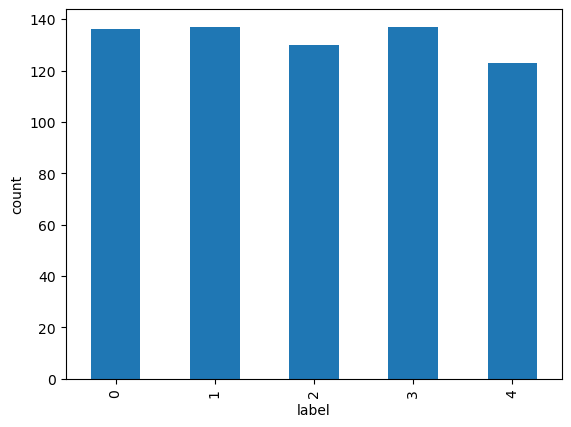

In [6]:
data = train_df.groupby('label').size()
data.plot.bar(xlabel='label', ylabel='count')

<AxesSubplot:xlabel='label', ylabel='count'>

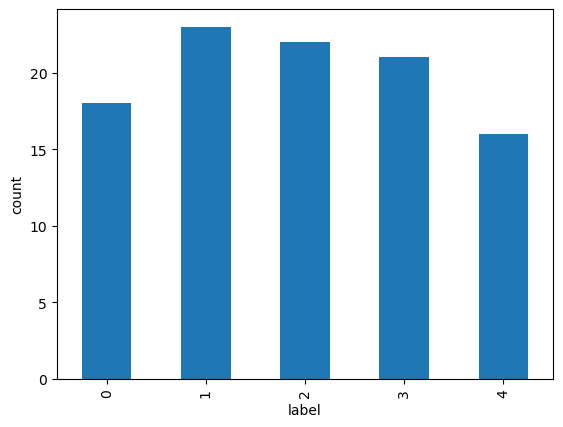

In [7]:
data = val_df.groupby('label').size()
data.plot.bar(xlabel='label', ylabel='count')

In [8]:
# Size (Height and Width of Data)

Conclusion:
<li> Data is quite balance </li>
<li> Image size is very different between image </li>

### 1.3 Data Generator and Transform
Cause data is left and right sensitive, up and down sensitive, so it would be better to not clip, rotate it in spatial
Cause data is sequence, so we should not random choose the frame order

We can change the contrast and brightness of image
https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

In [9]:
def resize_img(im, desired_size = dest_size[0]):
    """
        Resize image with keep aspect ratio
    """
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

def change_brightness(image):
    alpha = np.random.uniform(0.75, 1.25)
    beta = np.random.uniform(0, 100)
    new_image = np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def add_noise(image, threshold = 70):
    """
        Add salt and pepper noise if get random int > threshold
    """
    random_value = np.random.randint(0, 100)
    if random_value > threshold:
        image = image/255.0
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        out = image*255
        return out
    else:
        return image

In [10]:
def generator(source_path, folder_list, batch_size, augmentation = False):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30,2)]#create a list of image numbers you want to use for a particular video, we are not using all the 30 images in a video, selected pickup of images
    while True:
        sample = np.random.permutation(folder_list)
        num_batches =int(len(sample)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y=dest_size[0]
            z=dest_size[1]
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = sorted(glob.glob(os.path.join(source_path, sample[folder + batch*batch_size].split(';')[0], "*"))) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # read image by pillow and resize to destination size, then convert to numpy
                    image = cv2.imread(imgs[item])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = np.array(image)
                    if augmentation:
                        image = change_brightness(image)
                    image = resize_img(image)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image=image/255.0

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image

                batch_labels[folder, int(sample[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


            # write the code for the remaining data points which are left after full batches
            cnt_img=0
            batch_cover = num_batches*batch_size
            rem = len(sample) - batch_cover
            if(len(sample)!=batch_cover):
                batch_data = np.zeros((rem,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((rem,5)) # batch_labels is the one hot representation of the output
                for folder in range(rem):
                    imgs = sorted(glob.glob(os.path.join(source_path, sample[folder + batch*batch_size].split(';')[0], "*"))) # read all the images in the folder
                    cnt_img+=1
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        # read image by pillow and resize to destination size, then convert to numpy
                        image = cv2.imread(imgs[item])
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = resize_img(image)
                        image = np.array(image)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image=image/255.0

                        batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image

                    batch_labels[folder, int(sample[folder + batch_size].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = './data/train'
val_path = './data/val'
num_train_sequences = len(train_df)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_df)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model buiding

In [12]:
def train_model(model, name, num_epochs = num_epochs, batch_size = batch_size):
    # train and val generator
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    # create folder for saving checkpoints
    model_name = 'model' + '_' + name

    if not os.path.exists(os.path.join(checkpoints_folder, model_name)):
        os.mkdir(os.path.join(checkpoints_folder, model_name))
    
    # optimizers
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                                   beta_1=0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   amsgrad=False,
                                   name='Adam'
                                  )
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print("###############################################")
    print("Model {} summary".format(name))
    print(model.summary())
    print("###############################################")
    
    # callbacks
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_folder, model_name, filepath),
                                                                 monitor='val_loss', 
                                                                 verbose=1, 
                                                                 save_best_only=True, 
                                                                 save_weights_only=False, 
                                                                 mode='auto', 
                                                                 period=1) #chekpoints to save model in .h5
    LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) #learning Rate
    EL = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=1e-5)
    callbacks_list = [checkpoint, LR, EL]
    
    # calculate step_per_epoch
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

    # Training process
    print("###############################################")
    print("Training model")
    history=model.fit(train_generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=num_epochs, verbose=1, 
                      callbacks=callbacks_list, 
                      validation_data=val_generator, 
                      validation_steps=validation_steps, 
                      class_weight=None, 
                      workers=1, 
                      initial_epoch=0)
    print("###############################################")
    return history

In [13]:
# plot accuracy & loss
def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## 2.1 Model 1
C3D inspired model

In [14]:
def Model01(nb_classes):
    """
        C3D Model
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes

    inputs = Input(input_shape)
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = MaxPool3D((1,2,2),strides=(1,2,2),padding='same')(x)

    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x)
    return model

In [15]:
model_01 = Model01(nb_classes = 5)
history_01 = train_model(model_01, name = '01')

###############################################
Model 01 summary
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 15, 128, 128, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 32, 32, 64)    0         
 3D)                                                          

Epoch 13/30
83/83 [==============================] - ETA: 0s - loss: 1.6162 - categorical_accuracy: 0.2424
Epoch 13: val_loss did not improve from 1.59367
83/83 [==============================] - 18s 218ms/step - loss: 1.6162 - categorical_accuracy: 0.2424 - val_loss: 1.6359 - val_categorical_accuracy: 0.2375 - lr: 0.0010
Epoch 14/30
83/83 [==============================] - ETA: 0s - loss: 1.6136 - categorical_accuracy: 0.2138
Epoch 14: val_loss did not improve from 1.59367
83/83 [==============================] - 18s 222ms/step - loss: 1.6136 - categorical_accuracy: 0.2138 - val_loss: 1.6531 - val_categorical_accuracy: 0.2125 - lr: 0.0010
Epoch 15/30
83/83 [==============================] - ETA: 0s - loss: 1.6205 - categorical_accuracy: 0.2568
Epoch 15: val_loss did not improve from 1.59367
83/83 [==============================] - 18s 212ms/step - loss: 1.6205 - categorical_accuracy: 0.2568 - val_loss: 1.6555 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 16/30
83/83 [=========

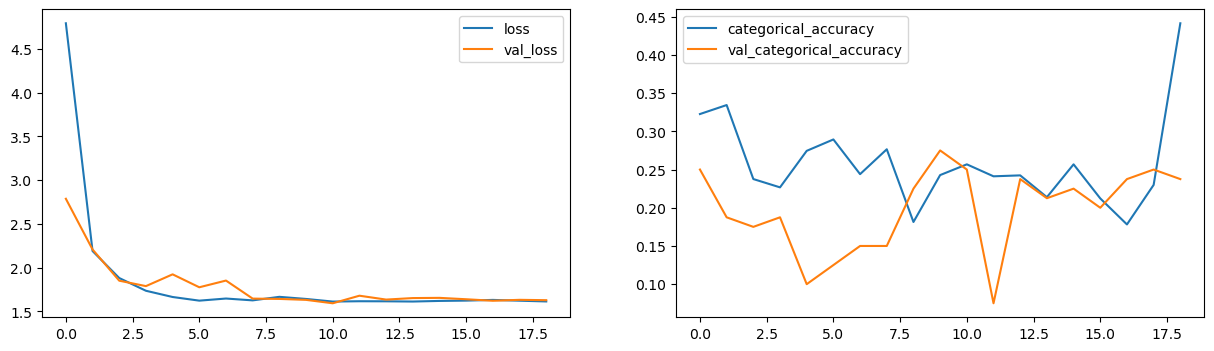

In [16]:
plot_history(history_01)

## 2.2 Model 2
What if 3D CNN go with VGG like (2 conv + 1 pool)

In [17]:
def Model02(nb_classes):
    """
        C3D Model
    """
    input_shape = (15, 128, 128, 3)
    weight_decay = 0.005
    nb_classes = nb_classes

    inputs = Input(input_shape)
    # block 1
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = Conv3D(32,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((1,2,2),strides=(1,2,2),padding='same')(x)
    
    # block 2
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    # block 3
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    
    # block 4
    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    
    # block 5
    x = Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = Activation('softmax')(x)

    model = Model(inputs, x)
    return model

In [ ]:
model_02 = Model02(nb_classes = 5)
history_02 = train_model(model_02, name = '02')

###############################################
Model 02 summary
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 128, 128, 32)  2624      
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 128, 128, 32)  27680     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 15, 64, 64, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 64, 64, 64)    55360     
                                                            

Epoch 11/30
83/83 [==============================] - ETA: 0s - loss: 1.7003 - categorical_accuracy: 0.2616
Epoch 11: val_loss improved from 1.78206 to 1.64592, saving model to ./checkpoints\model_02\model_02model-00011-1.70034-0.26164-1.64592-0.30000.h5
83/83 [==============================] - 36s 433ms/step - loss: 1.7003 - categorical_accuracy: 0.2616 - val_loss: 1.6459 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 12/30
83/83 [==============================] - ETA: 0s - loss: 1.6669 - categorical_accuracy: 0.2958
Epoch 12: val_loss did not improve from 1.64592
83/83 [==============================] - 35s 420ms/step - loss: 1.6669 - categorical_accuracy: 0.2958 - val_loss: 1.7033 - val_categorical_accuracy: 0.2125 - lr: 0.0010
Epoch 13/30
83/83 [==============================] - ETA: 0s - loss: 1.6307 - categorical_accuracy: 0.3628
Epoch 13: val_loss did not improve from 1.64592
83/83 [==============================] - 37s 450ms/step - loss: 1.6307 - categorical_accuracy: 0.3

In [ ]:
plot_history(history_02)

## 2.3 Model 3

## 2.4 Model 4

## 2.5 Model 5

## 2.6 Model 6

## 2.7 Model 7

## 2.8 Model 8

## 2.9 Model 9

## 2.10 Model 10

## 2.11 Model 11

## 2.12 Model 12